## LSST Afterglow detection metrics

Notebook for a mocked up GRB afterglow lightcurve. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False

### On-axis afterglows

On-axis afterglows decay as $F \sim t^{-\alpha}$ until a jet break, with $\alpha \sim 1$.

This requires subclassing `TransientMetric`, which assumes linear rise & decays in magnitude. We therefore have writted `GRBTransientMetric` that synthesizes the appropriate lightcurve shape.

We will use the rough numbers in 2011PASP..123.1034J: a Gaussian with $\mu$=15.35 mag, $\sigma=1.59$ in R-band at 1 minute after explosion, $\alpha = 1.0$.  
The right way to do this is not to assume fiducial values, but to simulate a cosmological population of events.


### GRBTransientMetric

In [3]:
from mafContrib import GRBTransientMetric, TripletBandMetric

We'll calculate detection fractions for one, two, and three detections.  For testing we may want to use one year at a time:

Now let's plot the lightcurves.  Because we include a random draw from the brightness distribution these plots will change each time we re-execute the cell.

In [13]:
surveyDuration=10
if surveyDuration < 10:
    year = 3
    sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
else:
    sqlconstraint = ''

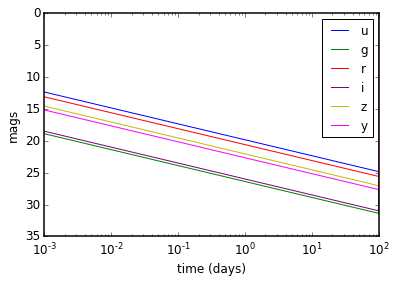

In [14]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 100 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=surveyDuration, transDuration=transDuration)


times = np.logspace(-3,2,500)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.legend()

In [15]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=16)

summaryMetrics = [metrics.MinMetric(), metrics.MeanMetric(), metrics.MaxMetric(), 
                  metrics.MedianMetric(), metrics.RmsMetric(), 
                 metrics.PercentileMetric(percentile=25), metrics.PercentileMetric(percentile=75)]
# Configure some metrics
metricList = []
# What fraction of transients are detected at least once?
metricList.append(transMetric)
# create metrics for 2 and 3 detections
m2 = GRBTransientMetric(alpha= 1., surveyDuration=surveyDuration, nPerFilter=2, metricName='GRBTransientMetric_k2')
#m2 = TripletBandMetric()
metricList.append(m2)
m3 = GRBTransientMetric(alpha= 1., surveyDuration=surveyDuration, nPerFilter=3, metricName='GRBTransientMetric_k3')
metricList.append(m3)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [16]:
# Set the database and query
runName = 'minion_1016'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with no constraint.
Found 2447931 visits
Running:  [0, 1, 2]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with  sqlconstraint now.
monopole: 0.0141993  dipole: lon: -164.528, lat: -11.5492, amp: 0.00189583
monopole: 0.0579858  dipole: lon: 31.0844, lat: -74.3939, amp: 0.00872307
monopole: 0.0554973  dipole: lon: -28.5975, lat: 40.2842, amp: 0.00383806
monopole: 0.0089537  dipole: lon: -121.551, lat: 3.2578, amp: 0.000990269
monopole: 0.00176264  dipole: lon: -104.185, lat: -33.9819, amp: 0.00140556
monopole: 0.0768079  dipole: lon: 58.8831, lat: -60.796, amp: 0.0242232


/smallfiles/ebellm/anaconda/envs/maf/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 350 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0026167  dipole: lon: -103.751, lat: -36.6856, amp: 0.00145237


/smallfiles/ebellm/anaconda/envs/maf/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 362 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.00479459  dipole: lon: -160.484, lat: 1.48149, amp: 0.000867987
monopole: 0.0149374  dipole: lon: -108.163, lat: -82.1272, amp: 0.0117005
monopole: 0.060109  dipole: lon: 78.3917, lat: -66.4968, amp: 0.0124417
monopole: 0.0322891  dipole: lon: 104.34, lat: 29.9784, amp: 0.00388116
monopole: 0.160342  dipole: lon: 96.2794, lat: -61.1185, amp: 0.0351582
monopole: 0.0217734  dipole: lon: -120.067, lat: -48.7787, amp: 0.00198538
monopole: 0.0352762  dipole: lon: 98.2946, lat: -58.6946, amp: 0.0140802
monopole: 0.104233  dipole: lon: 98.3531, lat: -57.9032, amp: 0.042497
monopole: 0.0444831  dipole: lon: -128.387, lat: -41.8367, amp: 0.00498129
monopole: 0.0516991  dipole: lon: 97.6985, lat: -57.7441, amp: 0.0212909
monopole: 0.0059043  dipole: lon: 107.851, lat: -87.6358, amp: 0.00328172


/smallfiles/ebellm/anaconda/envs/maf/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make 240 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.00545324  dipole: lon: 139.713, lat: -77.9896, amp: 0.00342518
monopole: 0.0131299  dipole: lon: 102.262, lat: -59.351, amp: 0.00602307
monopole: 0.0320698  dipole: lon: 103.46, lat: -58.0744, amp: 0.010903
monopole: 0.0344442  dipole: lon: 90.0445, lat: -49.2457, amp: 0.012067
monopole: 0.0229036  dipole: lon: 95.3161, lat: -66.011, amp: 0.0135356
monopole: 0.0140833  dipole: lon: -129.972, lat: -33.1935, amp: 0.00176658
Plotting complete.


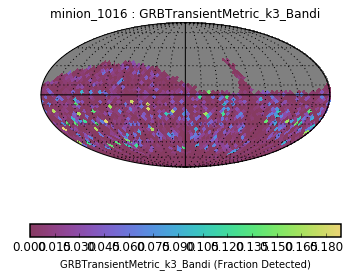

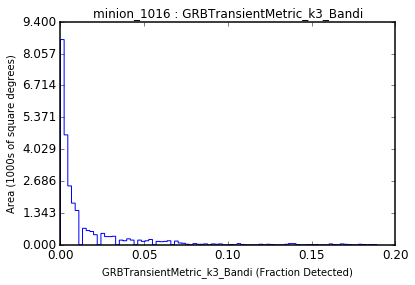

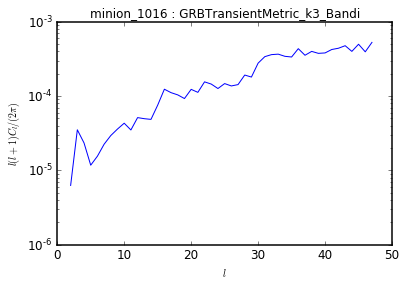

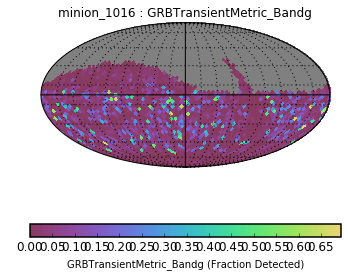

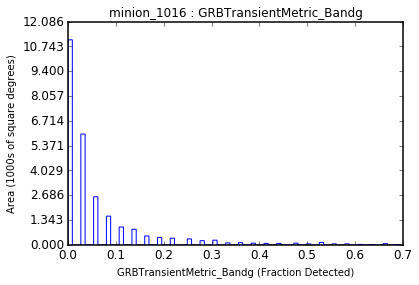

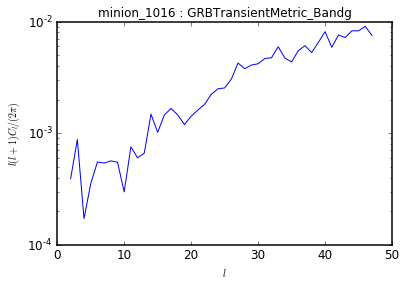

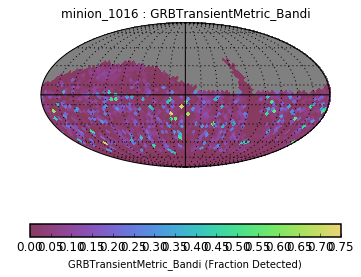

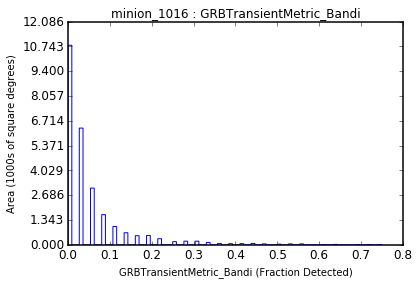

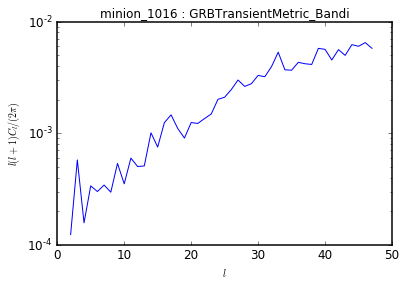

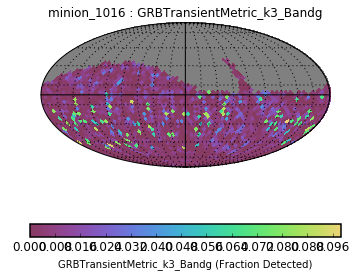

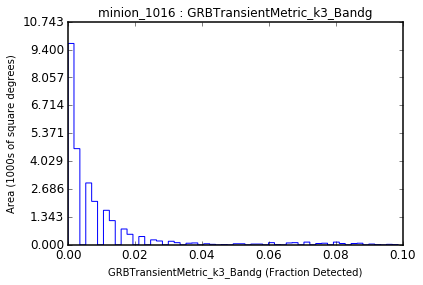

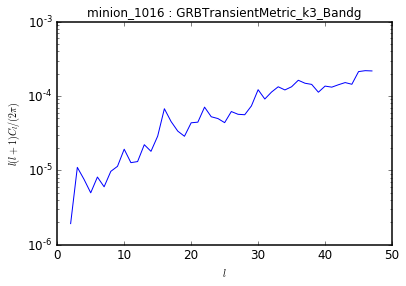

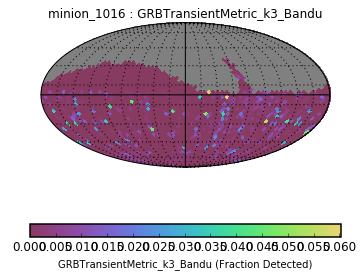

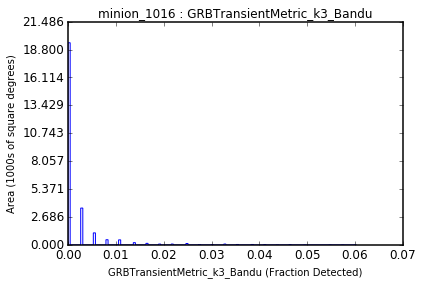

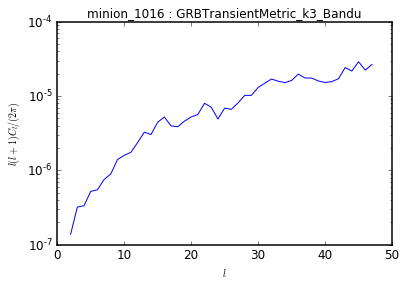

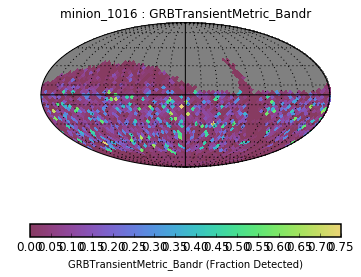

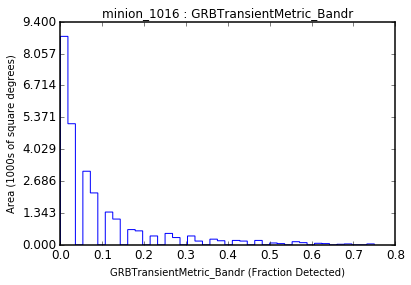

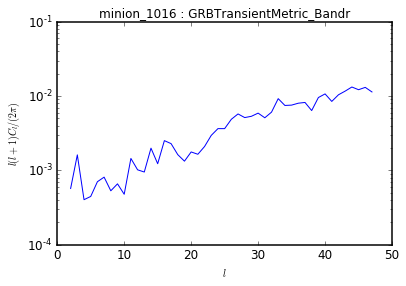

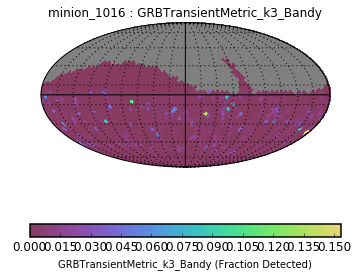

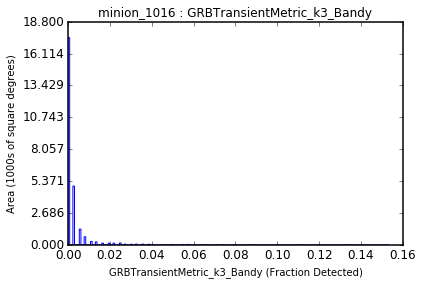

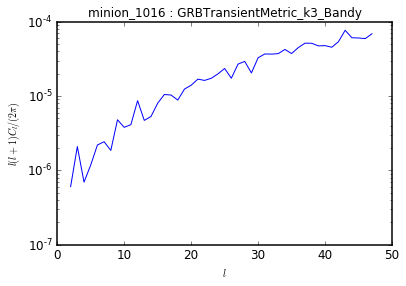

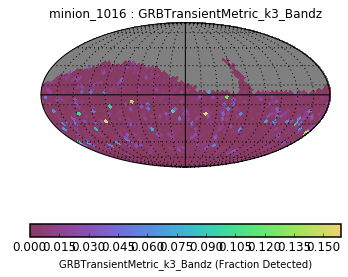

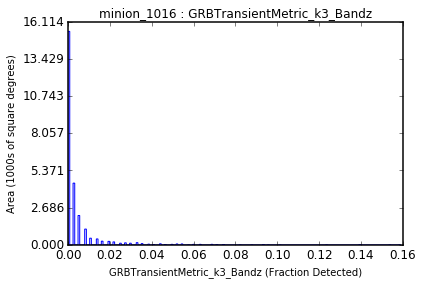

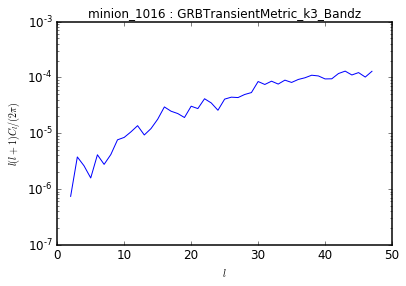

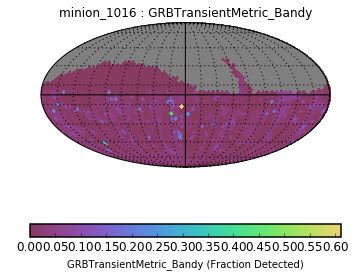

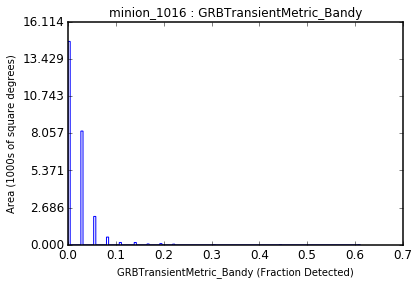

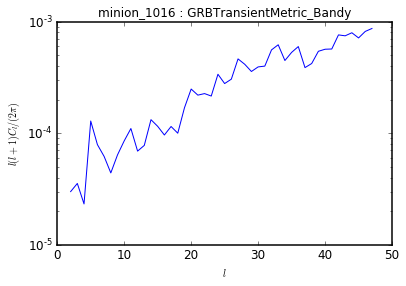

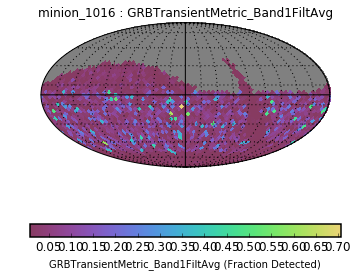

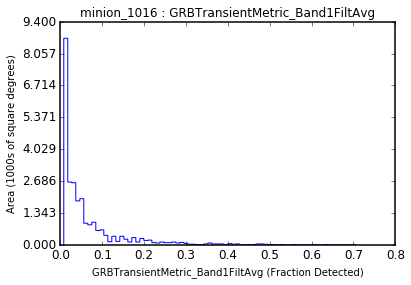

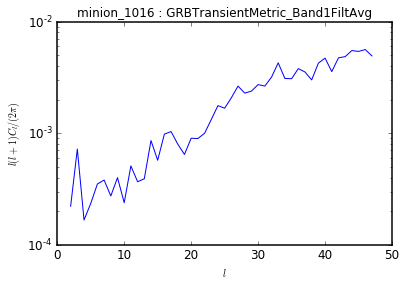

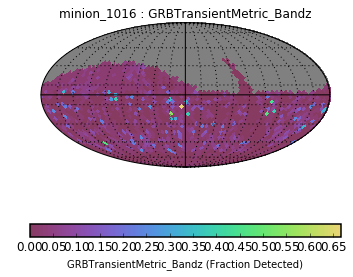

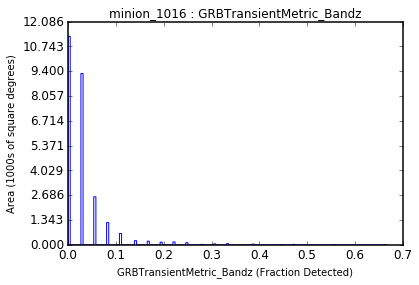

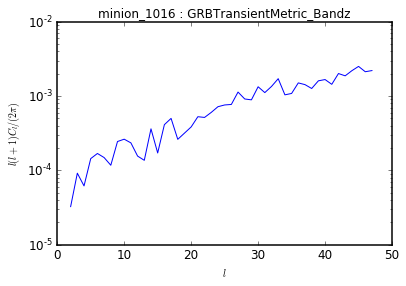

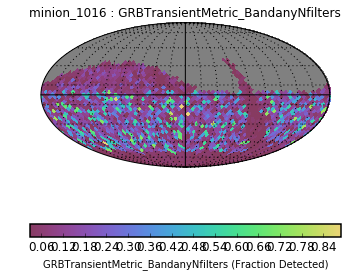

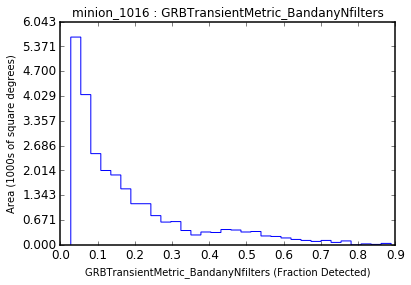

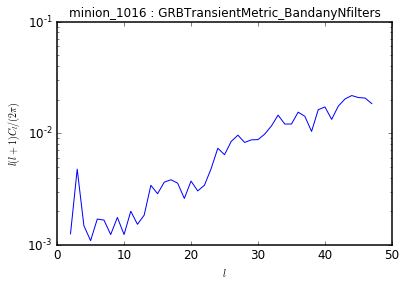

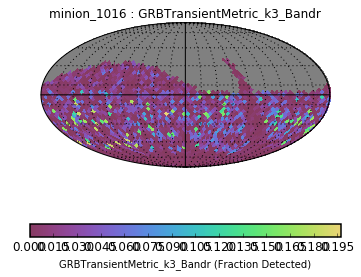

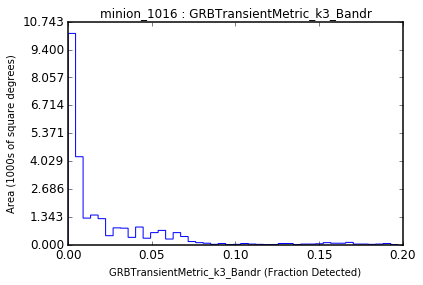

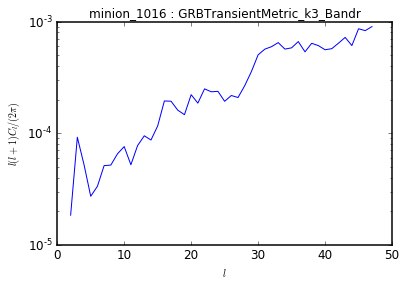

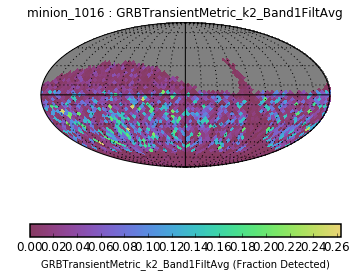

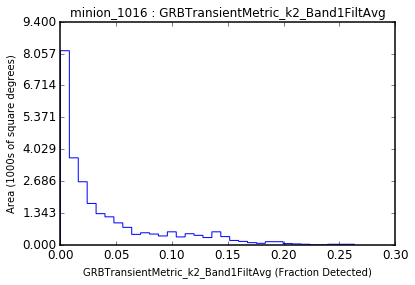

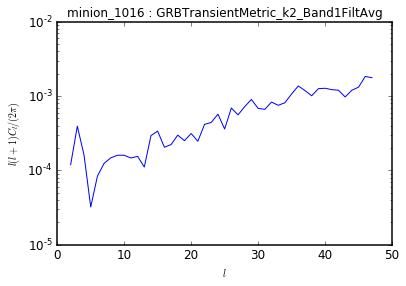

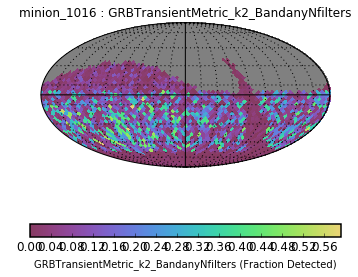

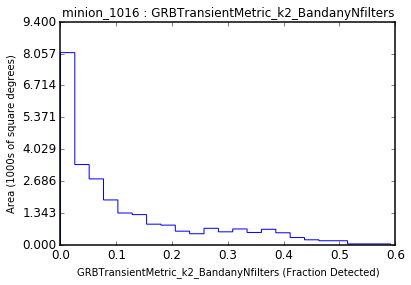

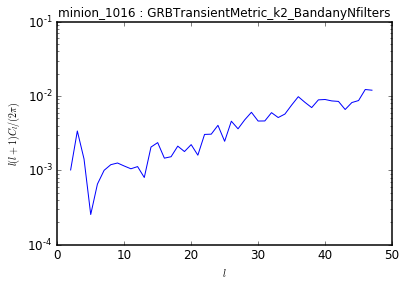

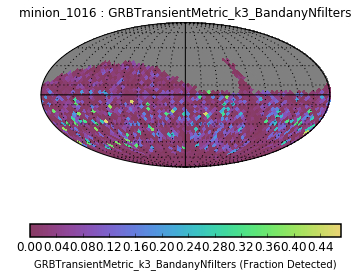

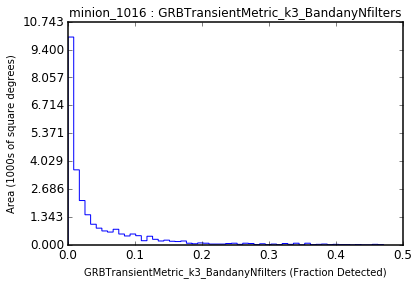

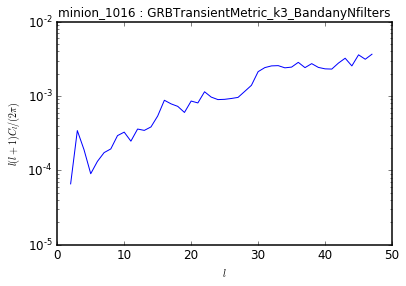

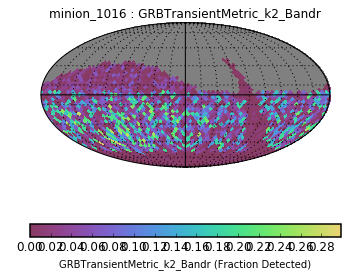

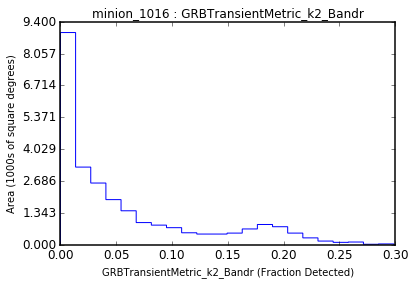

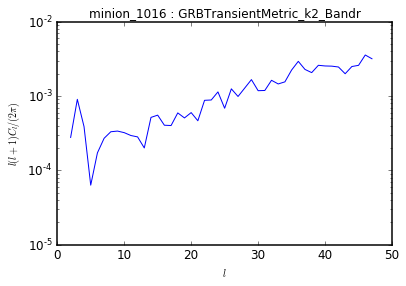

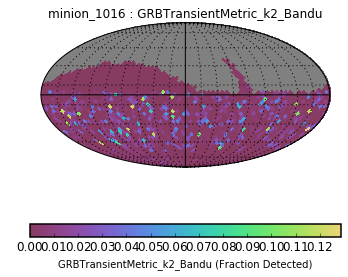

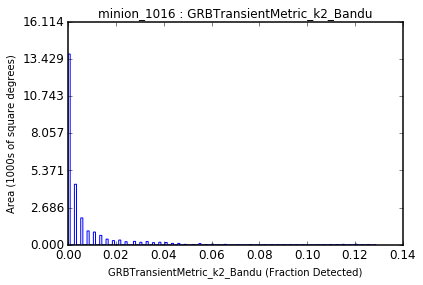

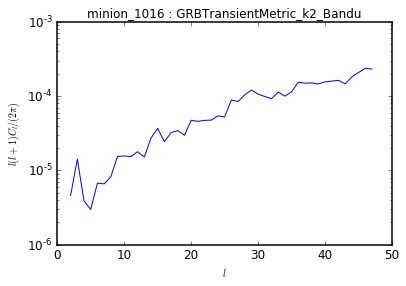

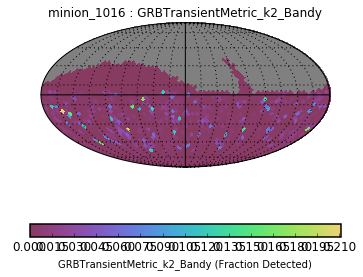

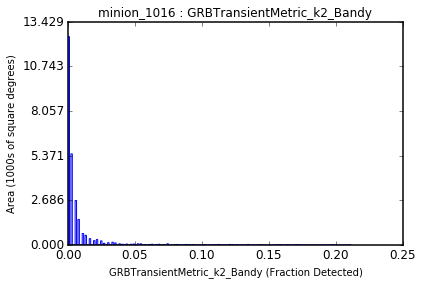

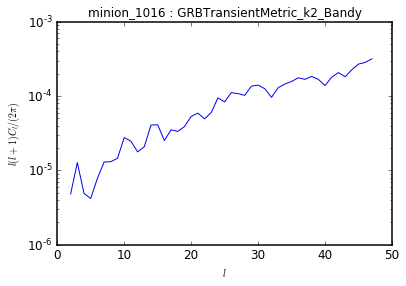

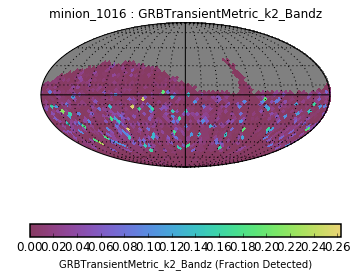

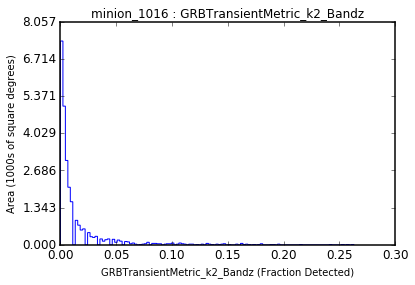

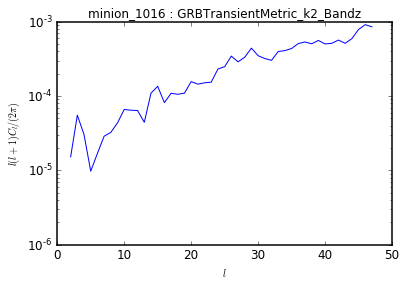

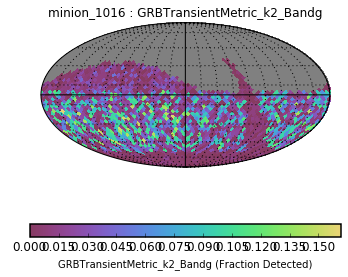

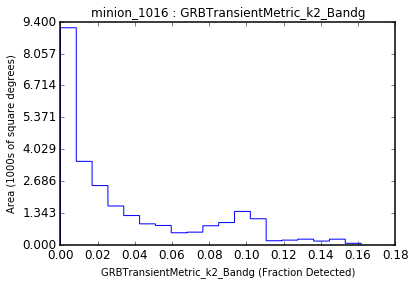

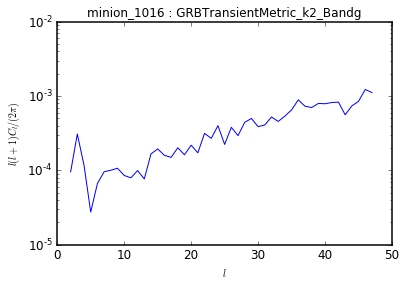

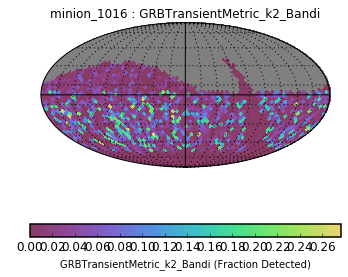

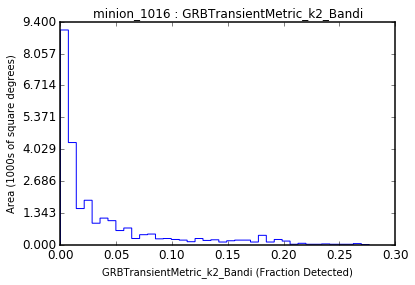

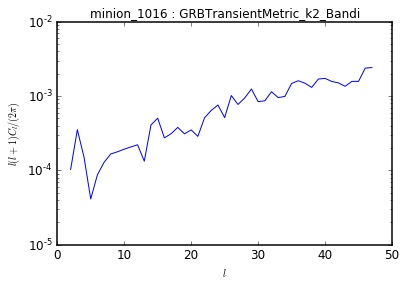

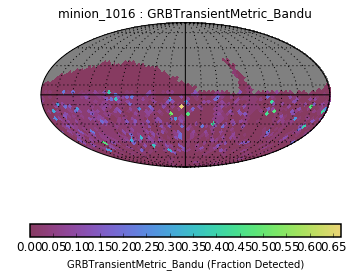

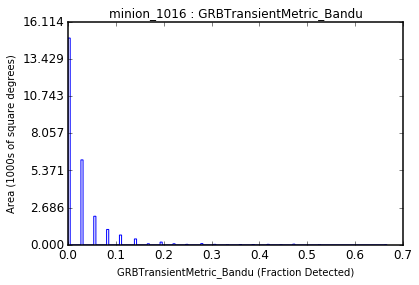

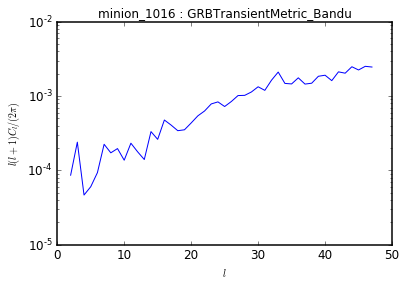

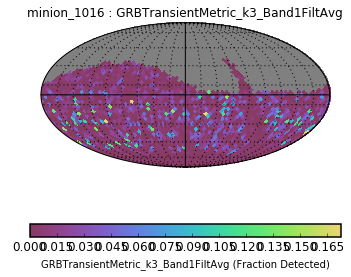

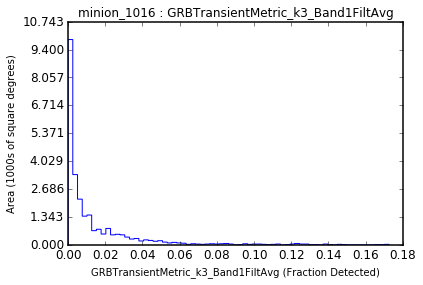

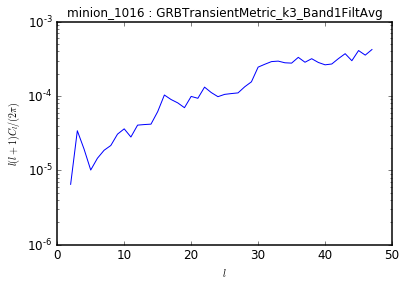

In [17]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [18]:
for key in sorted(bDict):
    if  bDict[key].metric.name.endswith('anyNfilters'):
        bDict[key].computeSummaryStats(resultsDb=resultsDb)
        print bDict[key].metric.name, bDict[key].summaryValues

GRBTransientMetric_BandanyNfilters {'25th%ile': 0.055555555555555552, 'Rms': 0.17161462241076481, '75th%ile': 0.22222222222222221, 'Min': 0.027777777777777776, 'Max': 0.88888888888888884, 'Median': 0.1111111111111111, 'Mean': 0.17266187050359713}
GRBTransientMetric_k2_BandanyNfilters {'25th%ile': 0.019178082191780823, 'Rms': 0.12983421948127216, '75th%ile': 0.17739726027397257, 'Min': 0.0, 'Max': 0.59178082191780823, 'Median': 0.06575342465753424, 'Mean': 0.11887257317433726}
GRBTransientMetric_k3_BandanyNfilters {'25th%ile': 0.0054794520547945206, 'Rms': 0.069740478622977359, '75th%ile': 0.057534246575342465, 'Min': 0.0, 'Max': 0.47123287671232877, 'Median': 0.01643835616438356, 'Mean': 0.045368793028199753}


So half of these afterglows are detected in one epoch, 11% in two, and 3% in three epochs (in any filter).

### GRB Decay Rates and LSST revist times

Let's try to understand these detection efficiencies by looking more generically at how often we have three observations in a single filter within a relevant interval to detect a GRB.

We'll start by determining how long LSST can observe afterglows parameterized as above--this is be band-dependent, as both LSST's limiting magnitude and the afterglow color vary.  For simplicity we consider just $r$ band for now.

3.96226973493


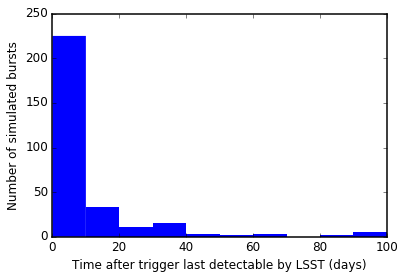

In [19]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 300 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=1, transDuration=transDuration)



def find_time_at_limiting_mag(limiting_mag,times,lc):
    return np.interp(limiting_mag,lc,times)

limit_times = []
lc_mins = []
#times = np.linspace(0,transDuration+1,500)
times = np.logspace(-2,2,500)
for i in range(300):
    # since we haven't included band-dependent afterglow brightness yet, 
    # look at the brightness distribution as a function of time in a single band
    filters = np.array(['r']*times.size)
    lc = transMetric.lightCurve(times,filters)
    lc_mins.append(lc[-1])
    limit_times.append(find_time_at_limiting_mag(24.7,times,lc))
#    plt.plot(times,lc)
#plt.xlabel('time (days)')
#plt.ylabel('mags')
#plt.gca().invert_yaxis()
#plt.xscale('log')
plt.hist(limit_times)
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Number of simulated bursts')

print np.percentile(limit_times,50)

So there is a substantial tail of afterglows detectable to tens or even hundreds of days after the burst.  Let's look at the cumulative histogram:

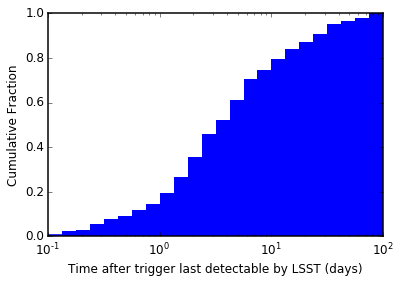

In [20]:
plt.hist(limit_times,normed=True,cumulative=True,bins=np.logspace(-1,2,25))
plt.xscale('log')
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Cumulative Fraction')

It is important to remember that we have not included a jet break in our lightcurve model here--in reality we expect the afterglow decay to decay faster at late times.  Still, it does appear that with appropriately-chosen cadences it should be possible to detect afterglows in multiple visits.